__In this project, I am going to conduct serveral hypothesis testings using the Northwind database (a free, open-source dataset created by Microsoft containing data from a fictional company) in order to optimize business operations.__ 
<br>
<br>
The dataset consists of a comprehensive schema that's shown below. 
<img src="Northwind_ERD_updated.png">

# Importing data

In [236]:
#import necessary libraries
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn.datasets as skd
sns.set()
sns.set_context('talk')
%matplotlib inline

In [237]:
#establish connection to database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

# Hypothesis Testing 1: Discount vs. Quantity?
_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_

__Null Hypothesis ($H_0$):__ Discount amount __does not__ have any statistically signifant effect of quantity ordered in an order.
<br>
__Alternative Hypothesis ($H_1$):__ DIscount amount __either increases or decreases__ the quantity of goods ordered in an order.

Since Discount and Quantity are stored in one single table, let's retrieve them from OrderDetails.

In [290]:
len(dis_quant)

2155

In [299]:
dis_quant = pd.DataFrame(c.execute('SELECT OrderID, Quantity, Discount FROM OrderDetail').fetchall())
dis_quant.columns = ['OrderID','Quantity','Discount']
print("Head of our dataset:")
print(dis_quant.head())
print("\nGeneral info: ")
print(dis_quant.info())
print("\nStatistical Summary:")
print(dis_quant.describe())
print("\nTest for repetition:")
print("There are repetitions, look further into the data!") \
     if dis_quant.OrderID.nunique() != len(dis_quant) \
     else print("No problem. Go ahead with your analysis.")

Head of our dataset:
   OrderID  Quantity  Discount
0    10248        12       0.0
1    10248        10       0.0
2    10248         5       0.0
3    10249         9       0.0
4    10249        40       0.0

General info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
OrderID     2155 non-null int64
Quantity    2155 non-null int64
Discount    2155 non-null float64
dtypes: float64(1), int64(2)
memory usage: 50.6 KB
None

Statistical Summary:
            OrderID     Quantity     Discount
count   2155.000000  2155.000000  2155.000000
mean   10659.375870    23.812993     0.056167
std      241.378032    19.022047     0.083450
min    10248.000000     1.000000     0.000000
25%    10451.000000    10.000000     0.000000
50%    10657.000000    20.000000     0.000000
75%    10862.500000    30.000000     0.100000
max    11077.000000   130.000000     0.250000

Test for repetition:
There are repetitions, look further into the data!


Indeed, we can have several different purchases within one Order. Putting our concern aside for now, let's first conduct a simple T-test to test for the difference in quantity ordered for those with discounts and without.

## Simple Testing

__Plotting distribution of quantities__

In [239]:
quant_wo_dis = dis_quant[dis_quant.Discount==0].Quantity
quant_w_dis = dis_quant[dis_quant.Discount!=0].Quantity

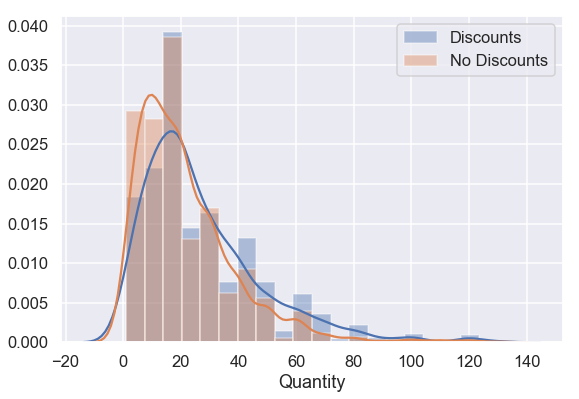

In [240]:
plt.figure(figsize = (9,6))
sns.distplot(quant_w_dis, bins=20, label='Discounts')
sns.distplot(quant_wo_dis, bins=20, label='No Discounts')
plt.legend()

__Running the Two-sided T-test__

In [241]:
T_result = stats.ttest_ind(quant_wo_dis,quant_w_dis, equal_var=False)

In [242]:
T_result

Ttest_indResult(statistic=-6.239069142123973, pvalue=5.65641429030433e-10)

Our p_value is extremely small. This means for any reasonable alpha we choose we can safely reject the null hypothesis and concludes that there is indeed a statistically significant different in quantity ordered for a product in an order.

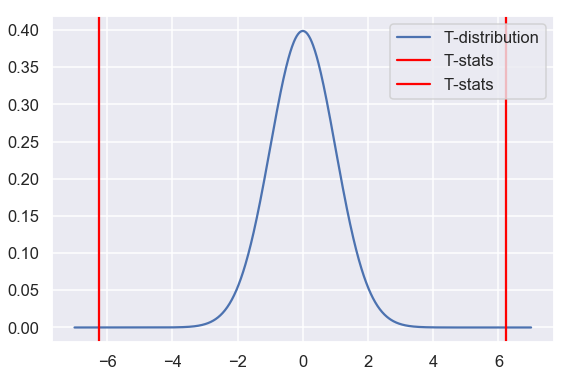

In [244]:
t_distribution = stats.t.pdf(np.linspace(-7,7,1000), len(quant_w_dis)+len(quant_wo_dis)-2)
plt.figure(figsize=(9,6))
plt.plot(np.linspace(-7,7,1000), t_distribution, label='T-distribution')
plt.axvline(T_result[0], c='red', label='T-stats')
plt.axvline(-T_result[0], c='red', label='T-stats')
plt.legend()

### Conclusion from our simple testing:
<br>
There is a difference (increase) in the quantity ordered when discounts are applied.

## A more elaborate approach into the problem
Our test above does indicate that there is a statistical significance in the difference of quantity ordered when discounts are applied. But this conclusion is useless in real business scenarios, as it tells us neither "for which product" nor "at which discount rate". To solve this, let's take on a more elaborate approach.

First, we can create a simple plot documenting the average quantity ordered with respect to discount. 

Text(0.5, 1.0, 'Average Quantity Sold vs. Discount Rate')

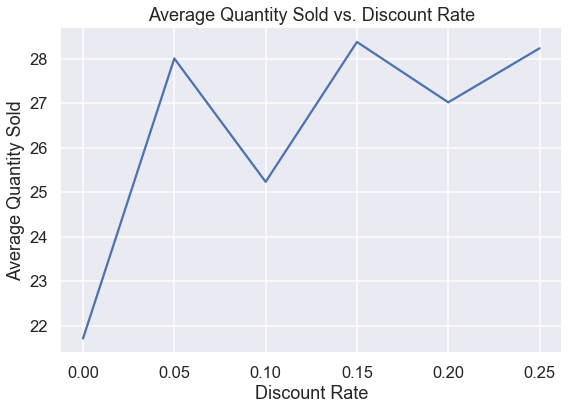

In [235]:
avg_quant = [dis_quant.Quantity[dis_quant.Discount==i].mean() for i in [0.00,0.05,0.10,0.15,0.20,0.25]]
plt.figure(figsize=(9,6))
plt.plot([0.00,0.05,0.10,0.15,0.20,0.25], avg_quant)
plt.xlabel('Discount Rate')
plt.ylabel('Average Quantity Sold')
plt.title('Average Quantity Sold vs. Discount Rate')

__From the graph:__
<br>
1. Discounts greatly stimulate quantity of a product in an order. 
<br>
2. However, the difference is significantly sensitive to discount rates--
discount rates at 5%, 15%, 25% bring the same level of increase in quantity purchased.
<br>

In fact, we can run another T-test to see discounts at these three discount rate are statistically different:

__Null Hypothesis ($H_0$):__ There is a statistically significant difference in the quantity of goods ordered in an order between discount rates of 5% and 15%.
<br>
__Alternative Hypothesis ($H_1$):__ There is no such statistically significant difference.

In [264]:
T_result = stats.ttest_ind(dis_quant.Quantity[dis_quant.Discount==0.05],
                           dis_quant.Quantity[dis_quant.Discount==0.15], equal_var=False)
T_result

Ttest_indResult(statistic=-0.15907926596432054, pvalue=0.873701937770792)

The p-value is way bigger than any $\alpha$ we would reasonably choose. So we cannot reject $H_0$, i.e. __there's no statistically difference between the 5% and 15% discount rates.__
Similarly, we can even show that there's no difference between all points with discounts rates. But there is indeed a statistically significant difference between any discount rate and no discount at all.

__Now, let's combine the product information and run the analysis.__

__Null Hypothesis ($H_0$):__ Discount __does not__ have any statistically signifant effect of quantity ordered in an order for product $x$.
<br>
__Alternative Hypothesis ($H_1$):__ Discount __either increases or decreases__ the quantity of goods ordered in an order for product $x$.

In [251]:
[len(dis_quant.Quantity[dis_quant.Discount==i]) for i in [0.00,0.05,0.10,0.15,0.20,0.25]]

[1317, 185, 173, 157, 161, 154]

In [308]:
dis_quant_wName = pd.DataFrame(c.execute('SELECT ProductID, Quantity, UnitPrice, Discount \
           FROM OrderDetail').fetchall())
dis_quant_wName.columns=['ProductID','Quantity','UnitPrice','Discount']
dis_quant_wName.Discount = [1 if i!=0 else 0 for i in dis_quant_wName.Discount]
dis_quant_wName.head()

,ProductID,Quantity,UnitPrice,Discount
0,11,12,14.0,0
1,42,10,9.8,0
2,72,5,34.8,0
3,14,9,18.6,0
4,51,40,42.4,0


In [309]:
dis_quant_wName.ProductID.nunique()

77

In [634]:
prod_wdis[27].mean()

43.75

In [678]:
#Create to separate dictionaries to store corresponding product name w/ or w/o discounts
prod_dis = {}
prod_wdis = {}
p_val = []
for i in dis_quant_wName.ProductID.unique():
    prod_dis[i] = dis_quant_wName[(dis_quant_wName.ProductID==i) & (dis_quant_wName.Discount!=0)].Quantity
    prod_wdis[i] = dis_quant_wName[(dis_quant_wName.ProductID==i) & (dis_quant_wName.Discount==0)].Quantity
print(f'It is {prod_dis.keys() == prod_wdis.keys()} that every product has both discounted sales and regular sales.\n')
##Run two sample T-test and fetch all p-values. 
print('Now, let us run the T-test and fetch all p-values')
for i in prod_dis.keys():
    p_val.append([i, stats.ttest_ind(prod_dis[i], prod_wdis[i], equal_var=False)[1]])
print('\nThe following products have a p_val > 0.05, and discounts should not be encouraged:')
print(sorted([i[0] for i in p_val if i[1]>0.05]))
print('\nThe following products have a p_val < 0.05 i.e. discounts have a significant impact in average quantity sold:')
print(sorted([i[0] for i in p_val if i[1]<0.05]))

It is True that every product has both discounted sales and regular sales.

Now, let us run the T-test and fetch all p-values

The following products have a p_val > 0.05, and discounts should not be encouraged:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 56, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]

The following products have a p_val < 0.05 i.e. discounts have a significant impact in average quantity sold:
[55, 57, 58]


To confirm our observation, let's plot product ID against its P-value.

Text(0.5, 1.0, 'Product against its p-value for $H_0$')

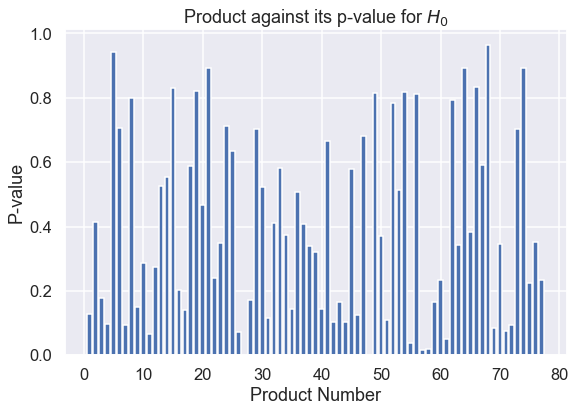

In [416]:
plt.figure(figsize=(9,6))
plt.bar(np.array(p_val)[:,0],np.array(p_val)[:,1])
plt.xlabel('Product Number')
plt.ylabel('P-value')
plt.title('Product against its p-value for $H_0$')

One last step, let's see what these products are.

In [428]:
product = pd.DataFrame(c.execute("""SELECT * from Product""").fetchall())
[product[1][product[0]==j] for j in sorted([i[0] for i in p_val if i[1]<0.05])]

[54    Pâté chinois
 Name: 1, dtype: object, 56    Ravioli Angelo
 Name: 1, dtype: object, 57    Escargots de Bourgogne
 Name: 1, dtype: object]

### Important Notes:
Although we seem to have reached important insights into the effects discounts have for different products, but recall that Degree of Freedom is an important parameter in the T-test, and small sample sizes might lead to high p_values and thus fail to give us any truly valuable insights. To verify this, let's calculate the absolute difference in quantity ordered for each product and plot them using a bar chart.

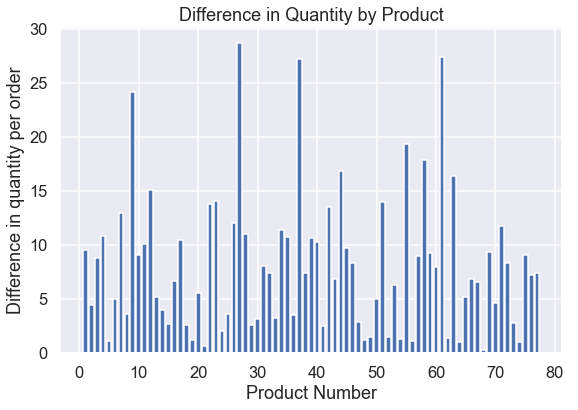

In [710]:
dif = []
for i in dis_quant_wName.ProductID.unique():
    dif.append([i, abs(prod_dis[i].mean()-prod_wdis[i].mean())])
plt.figure(figsize=(9,6))
plt.bar(np.array(dif)[:,0], np.array(dif)[:,1])
plt.xlabel('Product Number')
plt.ylabel('Difference in quantity per order')
plt.title('Difference in Quantity by Product')
plt.show()

Here we notice that changes brought by discounts do not lie in accordance with our p_value calculation. Therefore our previous calculation, though statistically valid, is meaningless in real business situations. This reveals some limitations of hypothesis testing using the T-test.

## Conclusion:
In this hypothesis testing, we start with the hypothesis $H_1$ that discounts have a significant effect on the quantity of a product sold in one order. We further explored how discounts rates and product type each affect quantity. Here are the conclusion:
1. Discounts have a significant effect on the quantity of a product sold in one order.
2. Difference in quantities are statistically insignificant for different discount rates, i.e. As long as we have discounts, discount rates do not affect the average quantity sold in one order.
3. Different products react differently to discounts. However, __our sample size is not big enough to give any business insights into the real effects discounts have for quantity__. Parameters other than product should be taken into consideration for better estimation.


However, there are still important aspects to take into consideration, and our test is by no means perfect. For example, we do not take into considerations other factors that might significantly influence the quantity sold in one order, such as location, extreme values, etc. Moreover, our calculation by product might not have an optimal statistical power (in order to solve this problem, we can refer to a larger dataset, such as the category of products instead of product names themselves). The following hypothesis testing will examine the last question.

# Hypothesis Testing 2: Category, Discount & Quantity?

## Create new DataFrame containing required information

In [553]:
# Inspect column names
c.execute("""PRAGMA table_info(Product)""").fetchall()

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'ProductName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'SupplierId', 'INTEGER', 1, None, 0),
 (3, 'CategoryId', 'INTEGER', 1, None, 0),
 (4, 'QuantityPerUnit', 'VARCHAR(8000)', 0, None, 0),
 (5, 'UnitPrice', 'DECIMAL', 1, None, 0),
 (6, 'UnitsInStock', 'INTEGER', 1, None, 0),
 (7, 'UnitsOnOrder', 'INTEGER', 1, None, 0),
 (8, 'ReorderLevel', 'INTEGER', 1, None, 0),
 (9, 'Discontinued', 'INTEGER', 1, None, 0)]

In [556]:
cat_dis_quant = pd.DataFrame(c.execute("""SELECT p.ID, o.Quantity, o.UnitPrice, o.Discount, c.CategoryName
                        FROM Product p
                        INNER JOIN OrderDetail o
                        ON p.Id = o.ProductId
                        INNER JOIN Category c
                        ON p.CategoryID = c.ID
                        """).fetchall())
cat_dis_quant.columns = ['ProductID','Quantity','UnitPrice','Discount','Category']
print(len(cat_dis_quant))
print(cat_dis_quant.Category.unique())
print('\n',len(cat_dis_quant) == len(dis_quant_wName))
print('\n',cat_dis_quant.head())

2155
['Dairy Products' 'Grains/Cereals' 'Produce' 'Seafood' 'Condiments'
 'Confections' 'Beverages' 'Meat/Poultry']

 True

    ProductID  Quantity  UnitPrice  Discount        Category
0         11        12       14.0       0.0  Dairy Products
1         42        10        9.8       0.0  Grains/Cereals
2         72         5       34.8       0.0  Dairy Products
3         14         9       18.6       0.0         Produce
4         51        40       42.4       0.0         Produce


Let's look at the mean quantity sold in each category and overall:

In [557]:
cat_dis_quant.groupby('Category').Quantity.mean()

Category
Beverages         23.594059
Condiments        24.527778
Confections       23.670659
Dairy Products    24.997268
Grains/Cereals    23.275510
Meat/Poultry      24.271676
Produce           21.985294
Seafood           23.275758
Name: Quantity, dtype: float64

## Stating the Hypothesis

__Null Hypothesis ($H_0$):__ Discount __does not__ have any statistically signifant effect of quantity ordered in an order for product of category $y$.
<br>
__Alternative Hypothesis ($H_1$):__ Discount __either increases or decreases__ the quantity of goods ordered in an order for product of category $y$.

For this hypothesis, we are going to use the T-test for independent means (Two-sample T-test). The procedure works similarly to what we already did.

In [679]:
cat_dis = {}
cat_wdis = {}
p_val = []
for i in cat_dis_quant.Category.unique():
    cat_dis[i] = cat_dis_quant[(cat_dis_quant.Category==i) & (cat_dis_quant.Discount!=0)]
    cat_wdis[i] = cat_dis_quant[(cat_dis_quant.Category==i) & (cat_dis_quant.Discount==0)]
print(f'It is {cat_dis.keys() == cat_wdis.keys()} that every product has both discounted sales and regular sales.\n')
##Run two sample T-test and fetch all p-values. 
print('Now, let us run the T-test and fetch all p-values:')
for i in cat_dis.keys():
    print(f'P-value for Category {i} is {stats.ttest_ind(cat_dis[i].Quantity, cat_wdis[i].Quantity, equal_var=False)[1]}')
    p_val.append([i, stats.ttest_ind(cat_dis[i].Quantity, cat_wdis[i].Quantity, equal_var=False)[1]])
print('\nThe following products have a p_val > 0.05, and discounts should not be encouraged:')
print(sorted([i[0] for i in p_val if i[1]>0.05]))
print('\nThe following products have a p_val < 0.05 i.e. discounts have a significant impact in average quantity sold:')
print(sorted([i[0] for i in p_val if i[1]<0.05]))

It is True that every product has both discounted sales and regular sales.

Now, let us run the T-test and fetch all p-values:
P-value for Category Dairy Products is 0.0004656666260826342
P-value for Category Grains/Cereals is 0.551447627988966
P-value for Category Produce is 0.4049781814399054
P-value for Category Seafood is 0.0294569773412451
P-value for Category Condiments is 0.00693227885982278
P-value for Category Confections is 0.445994667137246
P-value for Category Beverages is 0.0005777675384916129
P-value for Category Meat/Poultry is 0.020527835049366738

The following products have a p_val > 0.05, and discounts should not be encouraged:
['Confections', 'Grains/Cereals', 'Produce']

The following products have a p_val < 0.05 i.e. discounts have a significant impact in average quantity sold:
['Beverages', 'Condiments', 'Dairy Products', 'Meat/Poultry', 'Seafood']


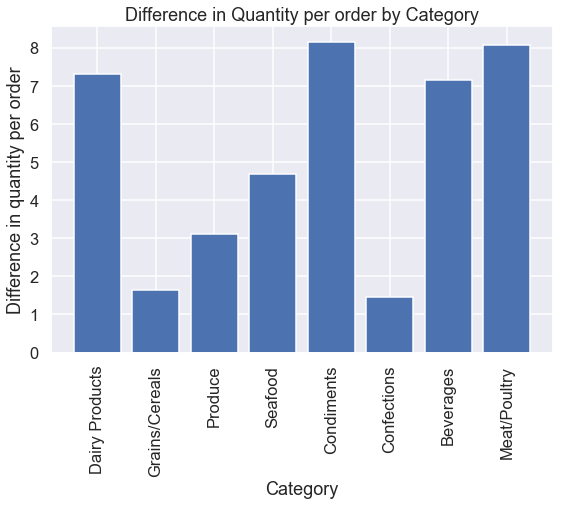

In [711]:
dif = []
for i in cat_dis_quant.Category.unique():
    dif.append([i, abs(cat_dis[i].Quantity.mean()-cat_wdis[i].Quantity.mean())])
plt.figure(figsize=(9,6))
plt.bar(np.array(dif)[:,0], np.array(dif)[:,1].astype(np.float))
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Difference in quantity per order')
plt.title('Difference in Quantity per order by Category')
plt.show()

Great! Now that we can make some insightful comments with regards to giving discounts to certain types of products.

## Conclusion

This hypothesis testing is a continuation of what we have done in the first test. While testing by products doesn't give us any business insights, looking at different categories does provide us with valuable information on giving out discounts. Our conclusion is as follows:
1. For most categories, providing discounts gives great incentives for more quantities of a product in an order.
2. When $\alpha = 0.05$, our test shows that we shall provide discounts for the following categories of goods: __Beverages, Condiments, Dairy Products, Meat/Poultry, Seafood__, while discounts on __Confections, Grains/Cereals, Produce__ do not produce statistically significant results.

# Hypothesis Testing 3: Response to Discount by Job Title

Now that we have explored how customers react differently to different categories of products when discounts are applied, let's look at the other half of the picture: let's explore if customers' job titles have any effects on their response to discounts. Specifically, I will try to answer the question: Is their any behavioral difference (i.e. change in quantity) between the owner and others in the company when discounts are applied? To do this, let's first formulate our hypothesis.
<br>
## Stating the Hypothesis
__$H_0$: Job title is not a statistically significant factor for the change in quantity of a product in one order when discounts are applied.
<br>
$H_1$: Job title does affect the change in quantity in a statistically significant way.__
<br>We're going to use the _two-sample T-test_ (owner vs. not owner) to determine the behavioral differences.

## Creating DataFrame and Inspecting the Data

In [871]:
#Get columns in OrderDetail
c.execute("""PRAGMA table_info(OrderDetail)""").fetchall()

[(0, 'Id', 'VARCHAR(8000)', 0, None, 1),
 (1, 'OrderId', 'INTEGER', 1, None, 0),
 (2, 'ProductId', 'INTEGER', 1, None, 0),
 (3, 'UnitPrice', 'DECIMAL', 1, None, 0),
 (4, 'Quantity', 'INTEGER', 1, None, 0),
 (5, 'Discount', 'DOUBLE', 1, None, 0)]

In [913]:
#Create DataFrame called Cust_order that takes in customer information along with order details, joined by OrderId.
cust_order = pd.DataFrame(c.execute("""SELECT c.CompanyName, c.ContactTitle, c.Region, od.Quantity, od.Discount
                            FROM Customer c
                            JOIN [Order] o
                            on c.Id=o.CustomerId
                            JOIN OrderDetail od
                            on o.Id=od.OrderId
                        """).fetchall())
cust_order.columns=['CompanyName','Owner','Region','Quantity','Discount']
cust_order.Owner = [1 if (i=='Owner'or i=='Owner/Marketing Assistant') else 0 for i in cust_order.Owner]
#Give Discount a boolean value
cust_order.Discount = [1 if i!=0 else 0 for i in supp_order.Discount]
cust_order.head(5)

,CompanyName,Owner,Region,Quantity,Discount
0,Vins et alcools Chevalier,0,Western Europe,12,0
1,Vins et alcools Chevalier,0,Western Europe,10,0
2,Vins et alcools Chevalier,0,Western Europe,5,0
3,Toms Spezialitäten,0,Western Europe,9,0
4,Toms Spezialitäten,0,Western Europe,40,0


Let's group our data by Owner and Discount.

In [918]:
print(cust_order.groupby('Owner').mean())
cust_order.groupby(['Owner','Discount']).Quantity.mean()

        Quantity  Discount
Owner                     
0      24.494253  0.387931
1      20.991124  0.387574


Owner  Discount
0      0           22.476995
       1           27.677037
1      0           18.937198
       1           24.236641
Name: Quantity, dtype: float64

## Running the Test

It seems that in general owners purchase less than other staff of a company do in for a product in one order. This is a nice observation. Let's confirm it using our T-test!

In [921]:
stats.ttest_ind(cust_order.Quantity[cust_order.Owner==1], cust_order.Quantity[cust_order.Owner==0], equal_var=False)

Ttest_indResult(statistic=-3.874966663682218, pvalue=0.00011779204069359587)

The p values is 0.00012, which is about 0.012%. This is sufficient enough for us to reject the null hypothesis for any $\alpha$ given in a business scenario. 
<br>Now, let's cut to the chase and assess the difference in behavior changes when discounts are applied.

__Owner avg quantity before & after discounts__:

In [935]:
stats.ttest_ind(cust_order.Quantity[(cust_order.Owner==1) & (cust_order.Discount==1)],\
                cust_order.Quantity[(cust_order.Owner==1) & (cust_order.Discount==0)], equal_var=False)

Ttest_indResult(statistic=3.3525190559391493, pvalue=0.0009203209535944768)

__Staff avg quantity before & after dicounts__:

In [936]:
stats.ttest_ind(cust_order.Quantity[(cust_order.Owner==0) & (cust_order.Discount==1)],\
                cust_order.Quantity[(cust_order.Owner==0) & (cust_order.Discount==0)], equal_var=False)

Ttest_indResult(statistic=5.135477815935306, pvalue=3.261957743673742e-07)

__After discounts quantity Owner & Staff__:

In [937]:
stats.ttest_ind(cust_order.Quantity[(cust_order.Owner==1) & (cust_order.Discount==1)],\
                cust_order.Quantity[(cust_order.Owner==0) & (cust_order.Discount==1)], equal_var=False)

Ttest_indResult(statistic=-2.2492103548233158, pvalue=0.025340971913587394)

All tests above shows a very small p-value, which is sufficient for us to reject the null hypothesis in each case. So we can conclude that discounts do have a statistically significant effect for both owners and staff when they make a purchase.

## Conclusion:
In this test, we inspected the difference job titles bring to the quantity purchased (w/ discounts and w/o discounts), i.e. if the contact person is the owner of the company or not. We have reached the following conclusions:
1. Being the owner decreases the quantity purchased for a product in an order in a statistically significant way. 
2. Discounts do have an statistically significant effect on both owners and staff when they make a purchase.
3. The p-value for the null hypothesis (i.e. quantity means are statistically the same) slightly increases (from 0.012% to 2.534% when discounts are applied. This might suggest a potential convergence in customer behabior brought by discounts. However, this difference is still significant enough for us to reject the null hypothesis.
4. Business-wise, the company should expect a bigger deal when doing business with company staff than with company manager (this suggests that communicating with salespeople might lead to higher profits, although we need to examine total sales price and other factors in order to confirm this hypothesis), and discounts should be applied to both cases.

# At last, several concerns about these tests

1. Test data is not quite normally distributed, should we use log transformation to transform the quantity before running our analysis? 
2. Our analysis tends to simplify matters. Every time we only take into few factors and we might ignore statistical effects brought by other parameters. Moreover, we do not rigorously test the statistical power of our sample data, and this might lead to inaccuracy and a higher rate of committing type II errors.
3. One problem I cannot quite figure out: how do I measure the difference of the difference of statistical means? For example, if I want to measure the change in the quantity sold w/ or w/o discounts, what data should be my input? 